In [1]:
import pandas as pd
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from IPython.core import display
import psycopg2
import os
homedir = os.getenv("HOME")
with open(homedir + "/.pgpass",'r') as pgfile:
    pgdat = pgfile.read().strip().split(":")
    pgurl = pgdat[0]
    pgport = pgdat[1]
    pgdb = pgdat[2]
    pguser = pgdat[3]
    pgpass = pgdat[4]

%load_ext sql
from sqlalchemy import create_engine
# sql info: https://github.com/catherinedevlin/ipython-sql
#uncomment for remote
pgport=3333
#pgport=5433
engine = create_engine('postgresql://postgres@localhost:%i/postgres' % pgport)
db = psycopg2.connect(host=pgurl, database=pgdb, user=pguser,password=pgpass,port=pgport)

/Users/shawnmeier/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def qry(q):
  return pd.read_sql_query(con = db, sql = q)
# pd.set_option("max_colwidth", None)
# pd.set_option('display.max_columns', None)
pd.set_option("display.latex.repr", False)
pd.set_option("display.latex.escape", True)

def iDisplay(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display.display(v)


In [3]:
%%sql postgresql://postgres@localhost:$pgport/postgres
select count(*) from apks where apkname not like 'jar_%' and apkname not like 'spec_%';

1 rows affected.


count
2


In [4]:
#count of total results
%sql select count(*) as Total_locations_computed from results

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


total_locations_computed
60


In [26]:
%%sql
select 
    (select count(*) from jobs where status = 'completed') as Completed_Jobs,
    (select count(id) from jobs 
       where stderr like '%Exception%no active body present for method%') as Body_Exception,
    (select count(id) from jobs where stderr like '%Exception%') as Exception,
    (select count(id) from jobs where stderr like '%Failed to parse reflective type reference%') as Refl_exception,
    (select count(id) from jobs where status like 'failed%') as worker_failure,
    (select count(id) from jobs where stdout like '%empty pred location%') as possible_cg_unsound,
    (select count(*) from jobs) as Total_Jobs

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


completed_jobs,body_exception,exception,refl_exception,worker_failure,possible_cg_unsound,total_jobs
35,3,3,0,0,13,384


In [21]:
%%sql
select id,replace(stderr,'$','\$') from jobs where stderr like '%Exception%' and stderr 
    not like '%no active body%' order by random() limit 3;

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


id,replace


Failing apks

In [7]:
%%sql
select cast(config::json->'apkPath' as text) from jobs 
        where stderr like '%Exception' group by cast(config::json->'apkPath' as text) ;

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


text


In [8]:
%%sql 
 select id from jobs where status like '%IOException%' limit 1;


 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


id


In [9]:
%%sql
select cast(config::json->'apkPath' as text) as app,count(*) as count from jobs group by app order by count desc;

 * postgresql://postgres@localhost:3333/postgres
2 rows affected.


app,count
"""${baseDir}/itkach.aard2/0.43/apk/itkach.aard2_43.apk""",293
"""${baseDir}/com.serwylo.lexica/0.12.0/apk/com.serwylo.lexica_1200.apk""",91


In [34]:
%%sql
select count(*),status from jobs group by status;

 * postgresql://postgres@localhost:3333/postgres
3 rows affected.


count,status
381,completed
1,"failed: org.postgresql.util.PSQLException: Unable to bind parameter values for statement.org.postgresql.util.PSQLException: Unable to bind parameter values for statement. at org.postgresql.core.v3.QueryExecutorImpl.execute(QueryExecutorImpl.java:345) at org.postgresql.jdbc.PgStatement.executeInternal(PgStatement.java:481) at org.postgresql.jdbc.PgStatement.execute(PgStatement.java:401) at org.postgresql.jdbc.PgPreparedStatement.executeWithFlags(PgPreparedStatement.java:164) at org.postgresql.jdbc.PgPreparedStatement.executeUpdate(PgPreparedStatement.java:130) at slick.jdbc.JdbcActionComponent$InsertActionComposerImpl$SingleInsertAction.$anonfun$run$15(JdbcActionComponent.scala:520) at slick.jdbc.JdbcBackend$SessionDef.withPreparedInsertStatement(JdbcBackend.scala:432) at slick.jdbc.JdbcBackend$SessionDef.withPreparedInsertStatement$(JdbcBackend.scala:429) at slick.jdbc.JdbcBackend$BaseSession.withPreparedInsertStatement(JdbcBackend.scala:489) at slick.jdbc.JdbcActionComponent$ReturningInsertActionComposerImpl.preparedInsert(JdbcActionComponent.scala:660) at slick.jdbc.JdbcActionComponent$InsertActionComposerImpl$SingleInsertAction.run(JdbcActionComponent.scala:517) at slick.jdbc.JdbcActionComponent$SimpleJdbcProfileAction.run(JdbcActionComponent.scala:28) at slick.jdbc.JdbcActionComponent$SimpleJdbcProfileAction.run(JdbcActionComponent.scala:25) at slick.basic.BasicBackend$DatabaseDef$$anon$3.liftedTree1$1(BasicBackend.scala:276) at slick.basic.BasicBackend$DatabaseDef$$anon$3.run(BasicBackend.scala:276) at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128) at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628) at java.base/java.lang.Thread.run(Thread.java:834)Caused by: java.io.IOException: Bind message length 1,185,209,679 too long. This can be caused by very large or incorrect length specifications on InputStream parameters. at org.postgresql.core.v3.QueryExecutorImpl.sendBind(QueryExecutorImpl.java:1631) at org.postgresql.core.v3.QueryExecutorImpl.sendOneQuery(QueryExecutorImpl.java:1910) at org.postgresql.core.v3.QueryExecutorImpl.sendQuery(QueryExecutorImpl.java:1433) at org.postgresql.core.v3.QueryExecutorImpl.execute(QueryExecutorImpl.java:315) ... 17 more"
2,acquired


 * postgresql://postgres@localhost:3333/postgres
382 rows affected.


Text(0.5, 0, 'time (min)')

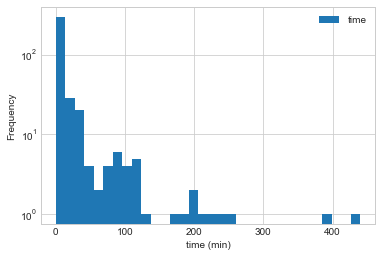

In [35]:
# Job runtimes
runtimes = %sql select ended - started as time from jobs where ended is not NULL;
runtimesDF = runtimes.DataFrame()
runtimesDF['time'] = runtimesDF['time'].apply(lambda x: x.total_seconds() / (60))
plt = runtimesDF.plot.hist(bins=32)
plt.set_yscale('log')
plt.set_xlabel('time (min)')

In [12]:
%%sql
select sum(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


sum
0:07:24.399000


In [13]:
%%sql
select count(*) from jobs where status like '%Exception%';

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count
0


In [14]:
%%sql
select count(*) from jobs where status = 'acquired';

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count
7


 * postgresql://postgres@localhost:3333/postgres
237 rows affected.


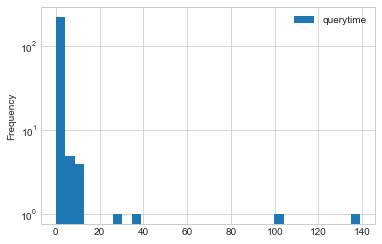

In [28]:
queryTime = %sql select querytime from results;
plt = queryTime.DataFrame().plot.hist(bins=32)
plt.set_yscale('log')

In [16]:
%%sql
select sum(querytime) from results;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


sum
106


In [36]:
%%sql 
select result,count(*) from results group by result;

 * postgresql://postgres@localhost:3333/postgres
5 rows affected.


result,count
"""Witnessed""",205
"""Timeout""",312
"""Itimeout""",129
"""Unreachable""",1948
"""Proven""",4993


TODO:
- use some other tool to get rid of simple deref like hopper

- [ ] break down proven number more and remove trivial things e.g.
void myMethod(v){
   v.foo(); // alarm
   v.bar(); // no alarm
 
- [ ] motivate why type based techniques aren't enough

Triage witness results
----------------------

In [20]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results 
                where result = '"Witnessed"' order by random() limit 10;

 * postgresql://postgres@localhost:5433/postgres
10 rows affected.


id,jobid,resultdata,clazz,?column?
1535,132,134,itkach.aard2.FileSelectListAdapter$2,"[""itkach.aard2.FileSelectListAdapter$2"",""java.io.File"",""java.io.File""]"
4137,363,316,com.serwylo.lexica.Lexica,"[""com.serwylo.lexica.Lexica""]"
6042,24,376,itkach.aard2.SlobDescriptorList$1,"[""itkach.aard2.SlobDescriptorList$1"",""itkach.aard2.SlobDescriptor"",""itkach.aard2.SlobDescriptor""]"
2212,111,148,itkach.slob.Slob$Blob,"[""itkach.slob.Slob$Blob""]"
3874,342,303,com.serwylo.lexica.LexicaConfig,"[""com.serwylo.lexica.LexicaConfig""]"
6764,321,385,com.serwylo.lexica.view.BoardView,"[""com.serwylo.lexica.view.BoardView"",""android.content.Context"",""android.util.AttributeSet""]"
466,20,59,itkach.aard2.DictionaryFinder$2,"[""itkach.aard2.DictionaryFinder$2"",""java.io.File"",""java.lang.String""]"
2418,163,170,itkach.slobber.Slobber$LogFormatter,"[""itkach.slobber.Slobber$LogFormatter"",""java.util.logging.LogRecord""]"
2798,246,208,itkach.aard2.DictionaryListAdapter$4,"[""itkach.aard2.DictionaryListAdapter$4"",""android.view.View""]"
1534,132,134,itkach.aard2.FileSelectListAdapter$2,"[""itkach.aard2.FileSelectListAdapter$2"",""java.io.File"",""java.io.File""]"


In [132]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, loc::json->'line' from results 
                where result = '"Witnessed"' and id = 7505;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


id,jobid,resultdata,clazz,?column?
7505,319,387,com.serwylo.lexica.view.LexicaView,"{'id': 1707901480, 'str': 'line: 436 $i0 = virtualinvoke $r1.<android.view.KeyEvent: int getUnicodeChar()>()'}"


Triage unreachable results
--------------------------

In [40]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz 
                from results where result = '"Unreachable"' order by random() limit 5;

 * postgresql://postgres@localhost:3333/postgres
5 rows affected.


id,jobid,resultdata,clazz
6626,365,354,com.serwylo.lexica.GameSaverPersistent
725,53,68,org.tukaani.xz.SimpleOutputStream
2202,167,178,org.tukaani.xz.SimpleInputStream
3986,250,238,org.tukaani.xz.LZMAInputStream
4269,216,243,itkach.aard2.ArticleWebView


TODO


In [41]:
%%sql
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'method'->>0 as varchar),'$','\$') as mname, 
        replace(cast(loc::json->'line' as varchar),'$','\$') as location 
        from results where id = 6626;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


id,jobid,resultdata,clazz,mname,location
6626,365,354,com.serwylo.lexica.GameSaverPersistent,"void save(com.serwylo.lexica.game.Board,int,int,java.lang.String,java.lang.String,int,java.util.Date,com.serwylo.lexica.game.Game\$GameStatus)","{""id"":1774795940,""str"":""line: 84 interfaceinvoke \$r7.<android.content.SharedPreferences\$Editor: android.content.SharedPreferences\$Editor putInt(java.lang.String,int)>(\""timeRemaining\"", \$i0)""}"


Triage unreachable locations
id	    jobid	resultdata	clazz
6626	365	    354	        com.serwylo.lexica.GameSaverPersistent
725	    53	    68	        org.tukaani.xz.SimpleOutputStream
2202	167	    178	        org.tukaani.xz.SimpleInputStream
3986	250	    238	        org.tukaani.xz.LZMAInputStream
4269	216	    243	        itkach.aard2.ArticleWebView



In [62]:
%%sql
select id,result,replace(cast(loc::json->'line' as varchar),'$','\$') as location 
    from results where loc like '%244 $r3%';

 * postgresql://postgres@localhost:5433/postgres
2 rows affected.


id,result,location
3305,"""Unreachable""","{""id"":1300528434,""str"":""line: 244 \$r3 = r0.<itkach.aard2.SettingsListAdapter\$5: itkach.aard2.SettingsListAdapter this\$0>""}"
3306,"""Unreachable""","{""id"":1598434875,""str"":""line: 244 \$r3 = r0.<itkach.aard2.SettingsListAdapter\$5: itkach.aard2.SettingsListAdapter this\$0>""}"


In [48]:
%%sql
select replace(cast(loc as varchar),'$','\$') from results where id = 1494;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


replace
"{""\$type"":""edu.colorado.plv.bounder.ir.AppLoc"",""method"":[""itkach.slob.Slob\$Blob run(itkach.slob.Slob\$RandomAccessFile)"",""itkach.slob.Slob\$4"",[""itkach.slob.Slob\$4"",""itkach.slob.Slob\$RandomAccessFile""],[""[{\""name\"":\""@this\"",\""localType\"":\""itkach.slob.Slob\$4\""}]"",""[{\""name\"":\""@parameter0\"",\""localType\"":\""itkach.slob.Slob\$RandomAccessFile\""}]""]],""line"":{""id"":1316001196,""str"":""line: 855 \$r1 = r0.<itkach.slob.Slob\$4: itkach.slob.Slob this\$0>""},""isPre"":true}"


Size of postgres data
=====================

In [73]:
%%sql
WITH RECURSIVE pg_inherit(inhrelid, inhparent) AS
    (select inhrelid, inhparent
    FROM pg_inherits
    UNION
    SELECT child.inhrelid, parent.inhparent
    FROM pg_inherit child, pg_inherits parent
    WHERE child.inhparent = parent.inhrelid),
pg_inherit_short AS (SELECT * FROM pg_inherit WHERE inhparent NOT IN (SELECT inhrelid FROM pg_inherit))
SELECT table_schema
    , TABLE_NAME
    , row_estimate
    , pg_size_pretty(total_bytes) AS total
    , pg_size_pretty(index_bytes) AS INDEX
    , pg_size_pretty(toast_bytes) AS toast
    , pg_size_pretty(table_bytes) AS TABLE
  FROM (
    SELECT *, total_bytes-index_bytes-COALESCE(toast_bytes,0) AS table_bytes
    FROM (
         SELECT c.oid
              , nspname AS table_schema
              , relname AS TABLE_NAME
              , SUM(c.reltuples) OVER (partition BY parent) AS row_estimate
              , SUM(pg_total_relation_size(c.oid)) OVER (partition BY parent) AS total_bytes
              , SUM(pg_indexes_size(c.oid)) OVER (partition BY parent) AS index_bytes
              , SUM(pg_total_relation_size(reltoastrelid)) OVER (partition BY parent) AS toast_bytes
              , parent
          FROM (
                SELECT pg_class.oid
                    , reltuples
                    , relname
                    , relnamespace
                    , pg_class.reltoastrelid
                    , COALESCE(inhparent, pg_class.oid) parent
                FROM pg_class
                    LEFT JOIN pg_inherit_short ON inhrelid = oid
                WHERE relkind IN ('r', 'p')
             ) c
             LEFT JOIN pg_namespace n ON n.oid = c.relnamespace
  ) a
  WHERE oid = parent
) a
ORDER BY total_bytes DESC limit 5;

 * postgresql://postgres@localhost:3333/postgres
5 rows affected.


table_schema,table_name,row_estimate,total,index,toast,table
public,resultdata,317.0,334 MB,16 kB,334 MB,48 kB
public,apks,0.0,70 MB,0 bytes,70 MB,8192 bytes
public,results,7767.0,6472 kB,192 kB,8192 bytes,6272 kB
pg_catalog,pg_depend,7725.0,1120 kB,624 kB,None,496 kB
pg_catalog,pg_proc,3034.0,1024 kB,336 kB,8192 bytes,680 kB


- [ ] can we partition locations into places that are "reasonably sound"
- [ ] easier story to say "we did every dereference site" for 6 apps
- [ ] witnessed is a terrible name, should be "alarm"